In [77]:
import nibabel as nib
from nilearn.image import resample_img, reorder_img
from glob import glob

import torch
from torchio import RandomElasticDeformation
import numpy as np
import matplotlib.pyplot as plt

from plot_image import show_slices
import transforms

In [78]:
def resample_voxel(data_nib, voxelsize,
                     target_shape=None, interpolation='nearest'):

    affine = data_nib.affine
    target_affine = affine.copy()

    factor = np.zeros(3)
    for i in range(3):
        factor[i] = voxelsize[i] / \
            np.sqrt(affine[0, i]**2 + affine[1, i]**2 + affine[2, i]**2)
        target_affine[:3, i] = target_affine[:3, i]*factor[i]

    new_nib = resample_img(data_nib, target_affine=target_affine,
                           target_shape=target_shape, interpolation=interpolation)

    return new_nib

In [8]:
img = reorder_img(nib.load(r"..\dataset\label_samseg\label\ABIDE_0050009_samseg.nii.gz"))
img_1mm = resample_voxel(img, (1,)*3)
print(f"orginal voxel size {img.header.get_zooms()}")
print(f"new voxel size {img_1mm.header.get_zooms()}")

orginal voxel size (1.0500001, 1.0507812, 1.0507812)
new voxel size (1.0, 1.0, 1.0)


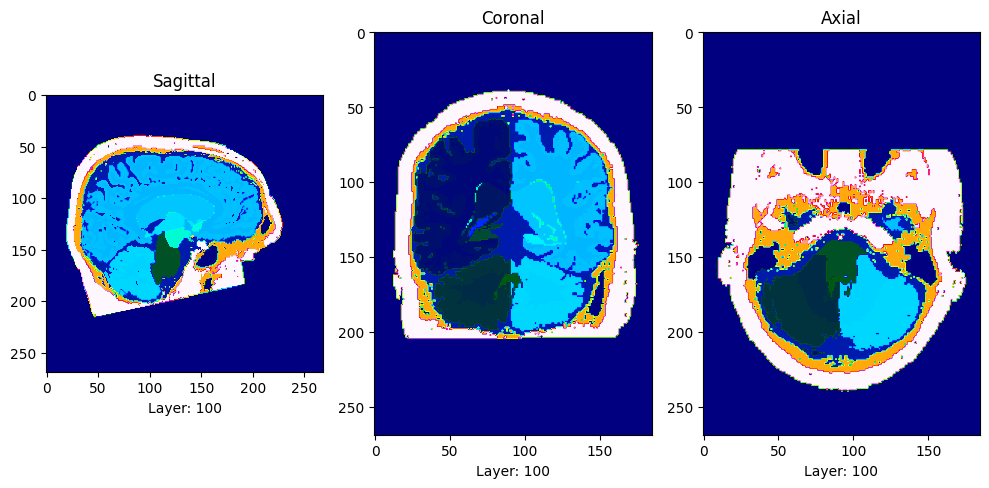

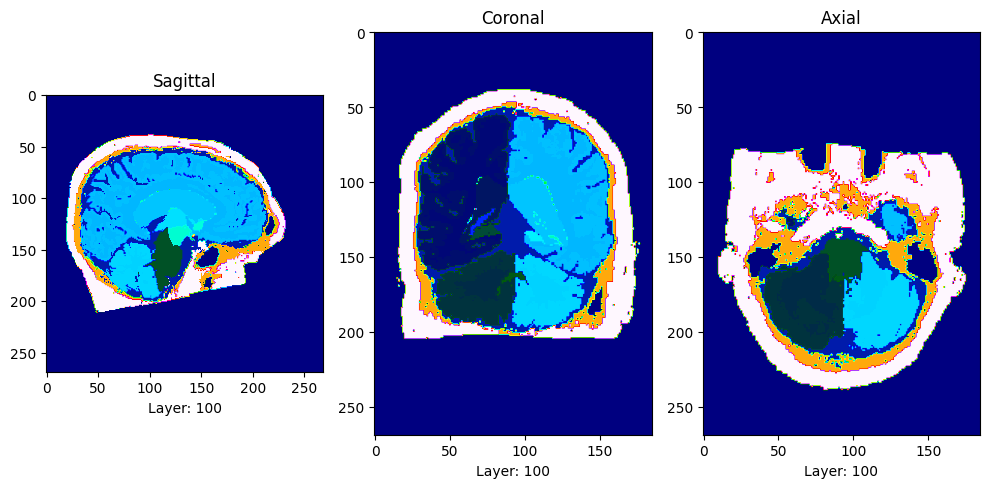

In [76]:
o = RandomElasticDeformation(num_control_points=10, max_displacement=10, 
                             image_interpolation="nearest")(img_1mm.get_fdata()[None, ...])

show_slices(img_1mm.get_fdata(), (100, 100, 100), "gist_ncar")
show_slices(o[0, ...], (100, 100, 100), "gist_ncar")

In [79]:
label = resample_voxel(
            reorder_img(nib.load(r"..\dataset\label_samseg\label\ABIDE_0050009_samseg.nii.gz")),
            (1, 1, 1)
        ).get_fdata()
label = torch.from_numpy(label).float()

new_label = transforms.LinearDeform(
    scales = (1, 1, 0.8, 1.2, 0.8, 1.2),
    degrees = (0, 0, 0, 0, -20, 20),
    trans=(0, 0, -30, 30, -30, 30)
)(label[None, None, ...])
new_label = RandomElasticDeformation(num_control_points=10, max_displacement=10, 
                             image_interpolation="nearest")(new_label[0, ...])[None, ...]

new_img = transforms.GMMSample()(new_label)
bias_img = transforms.RandomBiasField()(new_img)
bias_img = transforms.Rescale()(bias_img)
bias_img = transforms.GammaTransform(std=0.4)(bias_img)
down_img = transforms.RandomDownSample()(bias_img)

input_label = transforms.Rescale()(new_label).cpu()


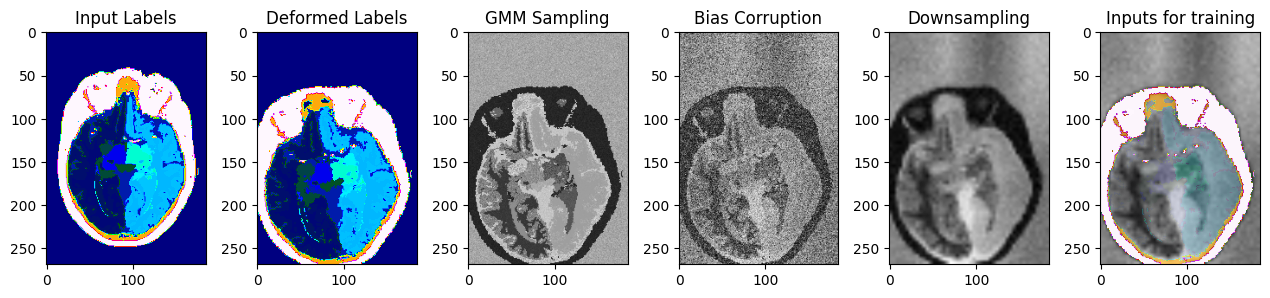

In [80]:
layer = 130

plt.figure()
plt.subplot(161)
plt.title("Input Labels")
plt.imshow(np.rot90(label[..., layer].cpu()), cmap="gist_ncar")

plt.subplot(162)
plt.title("Deformed Labels")
plt.imshow(np.rot90(new_label[0, 0, ..., layer].cpu()), cmap="gist_ncar")

plt.subplot(163)
plt.title("GMM Sampling")
plt.imshow(np.rot90(new_img[0, 0, ..., layer].cpu()), cmap="gray")

plt.subplot(164)
plt.title("Bias Corruption")
plt.imshow(np.rot90(bias_img[0, 0, ..., layer].cpu()), cmap="gray")

plt.subplot(165)
plt.title("Downsampling")
plt.imshow(np.rot90(down_img[0, 0, ..., layer].cpu()), cmap="gray")

plt.subplot(166)
plt.title("Inputs for training")
plt.imshow(np.rot90(down_img[0, 0, ..., layer].cpu()), cmap="gray")
plt.imshow(np.rot90(input_label[0, 0, ..., layer]), alpha = 1 * np.rot90(input_label[0, 0, ..., layer]), cmap="gist_ncar")

plt.tight_layout(rect=[0, 0.02, 2, 0.95])
plt.show()